In [747]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = 12, 8
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV
pd.options.display.max_columns = 100

In [748]:
df=pd.read_csv("parsed_df.csv")

In [749]:
dftouse=df.copy()
dftouse=dftouse.dropna()
dftouse=dftouse.sample(20000, replace=False)
del dftouse['Unnamed: 0']
del dftouse['PLAYER_ID']

In [750]:
#drop all rows with NaN values
dftouse = dftouse.dropna()

In [751]:
cols = list(dftouse)
cols.insert(0, cols.pop(cols.index('SHOT_MADE_FLAG')))
dftouse = dftouse.ix[:, cols]
dftouse.head()

,SHOT_MADE_FLAG,EVENTNUM,PERIOD_x,SCOREMARGIN,ACTION_BEFORE,CLOSE_DEF_DIST,DRIBBLES,LOCATION,PTS_TYPE,SHOT_CLOCK,SHOT_NUMBER,TOUCH_TIME,GAME_EVENT_ID,SHOT_DISTANCE,LOC_X,LOC_Y,SEC_LEFT_Q,SEC_LEFT_G,OFF_HEIGHT,DEF_HEIGHT,HEIGHT_DIFF,JUMP_SHOT,SHOT_DISTxCLOSE_DEF_DIST,HEIGHTxCLOSE_DEF_DIST,SHOT_DISTxJUMP_SHOT
65431,0,64,1,-7,4,0.7,0,0,2,13.4,2,1.9,64,1,-13,12,399,2559,81,72,9,0,0.7,6.3,0
177787,1,606,4,13,4,11.9,0,0,3,7.0,13,1.0,606,23,239,0,146,146,72,84,-12,1,273.7,-142.8,23
353820,1,104,2,7,12,7.2,0,0,2,4.7,1,0.9,104,18,184,9,698,2138,82,74,8,1,129.6,57.6,18
15479,1,130,1,28,4,1.1,2,0,2,13.4,1,2.2,130,2,-26,11,68,2228,72,76,-4,0,2.2,-4.4,0
93473,1,24,1,3,4,1.9,2,1,2,14.0,3,3.7,24,7,37,64,557,2717,79,78,1,0,13.3,1.9,0


In [752]:
dftouse.shape

(20000, 25)

In [753]:
#dftouse.isnull().sum()

In [754]:
#dftouse.isnull().any()

In [755]:
Xnames = list(dftouse.columns.values[1:25])

In [756]:
Xnames

['EVENTNUM',
 'PERIOD_x',
 'SCOREMARGIN',
 'ACTION_BEFORE',
 'CLOSE_DEF_DIST',
 'DRIBBLES',
 'LOCATION',
 'PTS_TYPE',
 'SHOT_CLOCK',
 'SHOT_NUMBER',
 'TOUCH_TIME',
 'GAME_EVENT_ID',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SEC_LEFT_Q',
 'SEC_LEFT_G',
 'OFF_HEIGHT',
 'DEF_HEIGHT',
 'HEIGHT_DIFF',
 'JUMP_SHOT',
 'SHOT_DISTxCLOSE_DEF_DIST',
 'HEIGHTxCLOSE_DEF_DIST',
 'SHOT_DISTxJUMP_SHOT']

In [757]:
#create train and test set
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [758]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    y_=indf[targetname]
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [759]:
%%time


clfForest = RandomForestClassifier()

parameters = {
    "n_estimators" : [10,50,100,500],
    #"n_estimators" : range(1, 21),
    #"max_features" : range(10,len(Xnames+1),2)
    "max_depth": [50,100,200,400],
    #"bootstrap": [True, False]
}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, dftouse, Xnames, 'SHOT_MADE_FLAG', 1, mask=mask, n_folds = 5, n_jobs = 4, score_func='f1')

using mask


/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 500, 'max_depth': 400} 0.575736566064 [mean: 0.52213, std: 0.00876, params: {'n_estimators': 10, 'max_depth': 50}, mean: 0.56076, std: 0.00896, params: {'n_estimators': 50, 'max_depth': 50}, mean: 0.56734, std: 0.01012, params: {'n_estimators': 100, 'max_depth': 50}, mean: 0.57097, std: 0.00909, params: {'n_estimators': 500, 'max_depth': 50}, mean: 0.52348, std: 0.00425, params: {'n_estimators': 10, 'max_depth': 100}, mean: 0.56460, std: 0.01313, params: {'n_estimators': 50, 'max_depth': 100}, mean: 0.57134, std: 0.01039, params: {'n_estimators': 100, 'max_depth': 100}, mean: 0.57528, std: 0.00961, params: {'n_estimators': 500, 'max_depth': 100}, mean: 0.52086, std: 0.00930, params: {'n_estimators': 10, 'max_depth': 200}, mean: 0.56605, std: 0.01262, params: {'n_estimators': 50, 'max_depth': 200}, mean: 0.56589, std: 0.01175, params: {'n_estimators': 100, 'max_depth': 200}, mean: 0.57520, std: 0.01183, params: {'n_estimators': 500, 'max_depth': 200}, mean: 0.52149

In [760]:
name_list

('PTS_TYPE',
 'LOCATION',
 'DRIBBLES',
 'JUMP_SHOT',
 'ACTION_BEFORE',
 'HEIGHT_DIFF',
 'off_height',
 'def_height',
 'SHOT_NUMBER',
 'SHOT_DISTxJUMP_SHOT',
 'EVENTNUM',
 'GAME_EVENT_ID',
 'TOUCH_TIME',
 'HEIGHTxCLOSE_DEF_DIST',
 'SEC_LEFT_G',
 'CLOSE_DEF_DIST',
 'LOC_X',
 'SCOREMARGIN',
 'SEC_LEFT_Q',
 'SHOT_CLOCK',
 'LOC_Y',
 'SHOT_DISTxCLOSE_DEF_DIST',
 'SHOT_DIST')

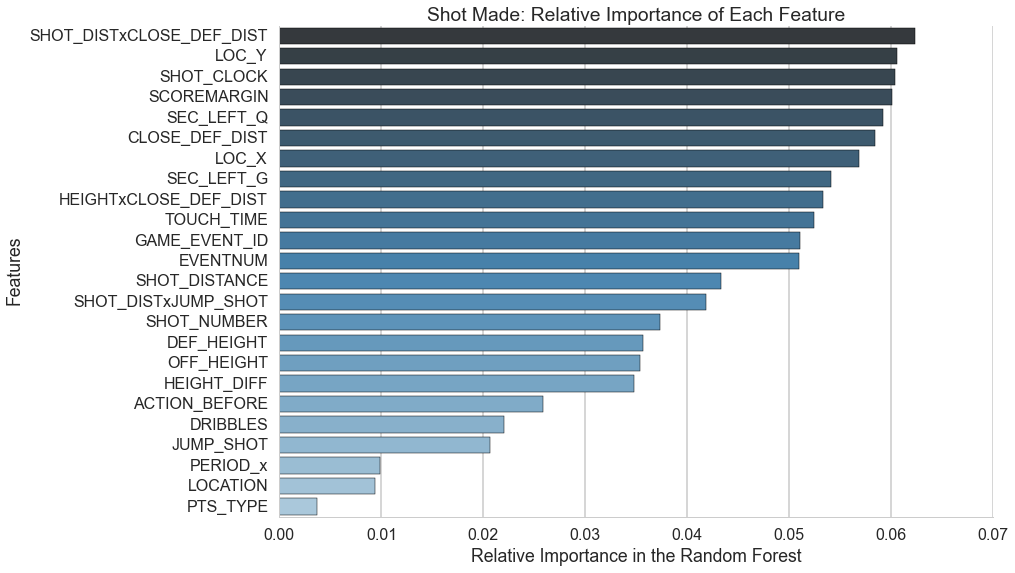

In [761]:
importance_list = clfForest.feature_importances_
name_list = dftouse.columns
importance_list, name_list = zip(*sorted(zip(importance_list, Xnames)))
ax = sns.barplot(y=range(len(name_list)),x=list(reversed(importance_list)), orient='h', palette="Blues_d")
ax.set_xlabel('Relative Importance in the Random Forest')
ax.set_ylabel('Features')
ax.set_title('Shot Made: Relative Importance of Each Feature')
ax.set_yticklabels(list(reversed(name_list)));
sns.despine()
plt.savefig('Baseline Relative Importance.png')